# Car License Plate OCR

In this notebook, I use a Tensorflow model from Tensorflow Model Garden to detect car license plates in image data from a Kaggle dataset containing about 450 images of car license plates accompanied by XML files containing bounding boxes and the values of the license plates. Then I use easyocr to read these license plates.

In [1]:
import os

import tarfile
import urllib.request

import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
from object_detection.builders import model_builder
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import re

import cv2 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pytesseract
import easyocr

C:\Users\nicko\anaconda3\envs\tf_object_detection\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating TFRecord Data

First, we need to train the license plate recognition model. I'll use a model from Tensorflow Model Garden, but I still have to train it for this specific task, and so I'll need to create TFRecord data.

In [2]:
DATA_ROOT_DIR = os.path.join('C:\\', '_local', 'data_sets', 'image', 'car_plates')
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'train') # Location of training images and XML lables
TEST_DIR = os.path.join(DATA_ROOT_DIR, 'test') # Location of testing images and XML labels

# Our initial model only looks for 1 thing: license plates
labels = [{'name': 'licence', 'id': 1}]

LABEL_MAP_PATH = os.path.join(DATA_ROOT_DIR, 'label_map.pbtxt')
with open(LABEL_MAP_PATH, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [3]:
# Code for converting data in TFRecord format if no TFRecords in data directory

GENERATE_TF_RECORD_SCRIPT_PATH = os.path.join(DATA_ROOT_DIR, 'generate_tfrecord.py')
TF_RECORD_TRAIN_PATH = os.path.join(DATA_ROOT_DIR, 'train.record')
TF_RECORD_TEST_PATH = os.path.join(DATA_ROOT_DIR, 'test.record')

if not os.path.exists(TF_RECORD_TRAIN_PATH):
    !python {GENERATE_TF_RECORD_SCRIPT_PATH} -x{TRAIN_DIR} -l{LABEL_MAP_PATH} -o{TF_RECORD_TRAIN_PATH} -i{TRAIN_DIR}
    
if not os.path.exists(TF_RECORD_TEST_PATH):
    !python {GENERATE_TF_RECORD_SCRIPT_PATH} -x{TEST_DIR} -l{LABEL_MAP_PATH} -o{TF_RECORD_TEST_PATH} -i{TEST_DIR}

## Downloading Model

In [4]:
# TF_OD_MODELS_ROOT_DIR is the directory containing the object detection models from Tensorflow Model Garden
TF_OD_MODELS_ROOT_DIR =  os.path.join('C:\\', '_local', 'py', 'tensorflow', 'models', 'research', 'object_detection')
TF_MODELS_DIR = os.path.join(TF_OD_MODELS_ROOT_DIR, 'downloaded_models')
TF_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
TF_MODEL_PATH = os.path.join(TF_MODELS_DIR, TF_MODEL_NAME)

if not os.path.exists(TF_MODEL_PATH):
    os.mkdir(TF_MODEL_PATH)
    
TF_MODEL_TAR_FILENAME = TF_MODEL_NAME + '.tar.gz'
TF_MODEL_TAR_PATH = os.path.join(TF_MODEL_PATH, TF_MODEL_TAR_FILENAME)
TF_MODEL_CKPT_PATH = os.path.join(TF_MODEL_PATH, 'checkpoint')
TF_MODEL_CFG_PATH = os.path.join(TF_MODEL_PATH, 'pipeline.config')
    
TF_MODELS_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/'
TF_MODEL_DATE = '20200711'
TF_MODEL_DOWNLOAD_LINK = TF_MODELS_DOWNLOAD_BASE + TF_MODEL_DATE + '/' + TF_MODEL_TAR_FILENAME

# Download desired model if not already downloaded
if not os.path.exists(TF_MODEL_CKPT_PATH):
    print('Downloading model. This may take a while... ', end='')
    urllib.request.urlretrieve(TF_MODEL_DOWNLOAD_LINK, TF_MODEL_TAR_PATH)
    tar_file = tarfile.open(TF_MODEL_TAR_PATH)
    tar_file.extractall(TF_MODELS_DIR)
    tar_file.close()
    os.remove(TF_MODEL_TAR_PATH)
    print('Done')
else:
    print('You already have the desired model')

You already have the desired model


## Training Model

In [5]:
PROJECT_ROOT_DIR = os.path.join('C:\\', '_local', 'py', 'car_plate_ocr')

# Root directory for this project's trained model
PROJECT_MODEL_ROOT_DIR = os.path.join(PROJECT_ROOT_DIR, TF_MODEL_NAME) 
if not os.path.exists(PROJECT_MODEL_ROOT_DIR):
    os.mkdir(PROJECT_MODEL_DIR)

# Directory for this project's model pipeline config
# Will initially be copy of Model Garden config, but we will change
PROJECT_MODEL_CFG_PATH = os.path.join(PROJECT_MODEL_ROOT_DIR, 'pipeline.config')
if not os.path.exists(PROJECT_MODEL_CFG_PATH):
    !copy {TF_MODEL_CFG_PATH} {PROJECT_MODEL_ROOT_DIR}

In [6]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(PROJECT_MODEL_CFG_PATH, "r") as f:
    proto_str = f.read()  
    text_format.Merge(proto_str, pipeline_config)  
    
model_config = config_util.get_configs_from_pipeline_file(PROJECT_MODEL_CFG_PATH)

In [7]:
# Path to initial checkpoint in Model Garden
FINE_TUNE_CKPT_PATH = os.path.join(TF_MODEL_CKPT_PATH, 'ckpt-0')

# Directory of this project's model checkpoints
PROJECT_MODEL_CKPTS_DIR = os.path.join(PROJECT_MODEL_ROOT_DIR, 'checkpoints')
if not os.path.exists(PROJECT_MODEL_CKPTS_DIR):
    os.mkdir(PROJECT_MODEL_CKPTS_DIR)

# If we have already performed training (and have checkpoints saved in this project's checkpoint directory)
# then this code finds the most recent checkpoint and sets that as the initial checkpoint for the next training session
current_ckpt_num = 0
for f in os.listdir(PROJECT_MODEL_CKPTS_DIR):
    search = re.search('ckpt-\d+', f)
    if search:
        ckpt_num = ''.join([s for s in search.group() if s.isdigit()])
        ckpt_num = int(ckpt_num)
        
        if ckpt_num > current_ckpt_num:
            current_ckpt_num = ckpt_num
            FINE_TUNE_CKPT_PATH = os.path.join(PROJECT_MODEL_CKPTS_DIR, search.group())
            
print(f'path of initial training checkpoint:\n{FINE_TUNE_CKPT_PATH}')

# Pipeline config customization for this project
pipeline_config.model.ssd.num_classes = len(labels) # How many things our model is detecting
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = FINE_TUNE_CKPT_PATH # Initial training checkpoint
pipeline_config.train_config.fine_tune_checkpoint_type = 'detection'
pipeline_config.train_input_reader.label_map_path = LABEL_MAP_PATH
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [TF_RECORD_TRAIN_PATH]
pipeline_config.eval_input_reader[0].label_map_path = LABEL_MAP_PATH
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [TF_RECORD_TEST_PATH]

path of initial training checkpoint:
C:\_local\py\car_plate_ocr\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\checkpoints\ckpt-16


In [8]:
# Get config for next training session
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(PROJECT_MODEL_CFG_PATH, 'wb') as f:
    f.write(config_text)

In [9]:
# Get command for training
TRAINING_SCRIPT_PATH = os.path.join(TF_OD_MODELS_ROOT_DIR, 'model_main_tf2.py')
cmd = (
    f'python {TRAINING_SCRIPT_PATH} '
    f'--model_dir={PROJECT_MODEL_ROOT_DIR} --pipeline_config_path={PROJECT_MODEL_CFG_PATH} --num_train_steps=1000'
)
print(cmd)

python C:\_local\py\tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=C:\_local\py\car_plate_ocr\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 --pipeline_config_path=C:\_local\py\car_plate_ocr\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\pipeline.config --num_train_steps=1000


In [10]:
# To train model, either execute the code in this cell or execute cmd in command prompt
#!{cmd}

In [11]:
# The directory new checkpoints are saved to must differ from the directory that the initial checkpoint is taken from,
# so the model saves new checkpoints in the parent directory of the old checkpoints
# Additionally, I broke up training into several sessions, but checkpoints are always saved numbered starting from 1,
# so I wanted to rename these to reflect the 'true' checkpoint number they represented
# Anyway, this code renames the new checkpoints appropriately and moves them to the old checkpoints directory

max_ckpt_num = current_ckpt_num
for f in os.listdir(PROJECT_MODEL_ROOT_DIR):
    reg = re.search('ckpt-\d+', f)
    if reg:
        ckpt_num = int(''.join([d for d in reg.group() if d.isdigit()]))
        
        if ckpt_num <= current_ckpt_num:
            ckpt_new_num_str = str(current_ckpt_num + ckpt_num)
            ckpt_new_name = re.sub('ckpt-\d+', f'ckpt-{ckpt_new_num_str}', f)
            
            if max_ckpt_num < current_ckpt_num + ckpt_num:
                max_ckpt_num = current_ckpt_num + ckpt_num
            
        src_path = os.path.join(PROJECT_MODEL_ROOT_DIR, f)
        dst_path = os.path.join(PROJECT_MODEL_CKPTS_DIR, ckpt_new_name)
        #print(f'{src_path} --> \n{dst_path}\n')
        
        os.rename(src_path, dst_path)
        
current_ckpt_num = max_ckpt_num

#old_ckpt_path = os.path.join(PROJECT_MODEL_CKPTS_DIR, 'checkpoint')
#new_ckpt_path = os.path.join(PROJECT_MODEL_ROOT_DIR, 'checkpoint')
#print(f'{old_ckpt_path} has been replaced with\n{new_ckpt_path}')
#os.replace(old_ckpt_path, new_ckpt_path)

In [12]:
# Get most recent version (presumably best performing) model
configs = config_util.get_configs_from_pipeline_file(PROJECT_MODEL_CFG_PATH)
model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
# Checkpoint 16 had very nice predictions
latest_ckpt_path = os.path.join(PROJECT_MODEL_CKPTS_DIR, f'ckpt-{current_ckpt_num}')
ckpt = tf.compat.v2.train.Checkpoint(model=model)
ckpt.restore(latest_ckpt_path).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)
    return detections

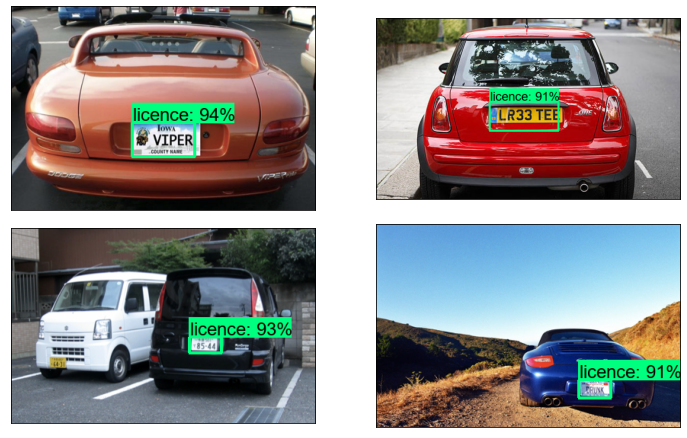

In [13]:
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH)
TEST_IMAGE_PATHS = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR)[:8] if f.split('.')[-1]=='png']
detection_images = []
test_image_detection_dictionaries = []

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(hspace=-.5)
for img_path, ax in zip(TEST_IMAGE_PATHS, axs.reshape(-1)):
    
    img = cv2.imread(img_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor) # Get detections in image

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # Insure detection classes are stored as ints
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    image_np_with_detections = image_np.copy()
    detection_images.append(image_np_with_detections)
    test_image_detection_dictionaries.append(detections)

    # Draw boxes for detections
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'], detections['detection_classes']+1, detections['detection_scores'], category_index,
        use_normalized_coordinates=True, max_boxes_to_draw=3, min_score_thresh=.68, agnostic_mode=False
    )

    plt_img = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB)
    ax.imshow(plt_img)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

## Applying OCR to Images

Since our model can identify license plates and their ROIs with reasonable accuracy, now we can apply OCR to the images contained in the bounding boxes: easyocr performed better than pytesseract (which performed terribly) here.

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


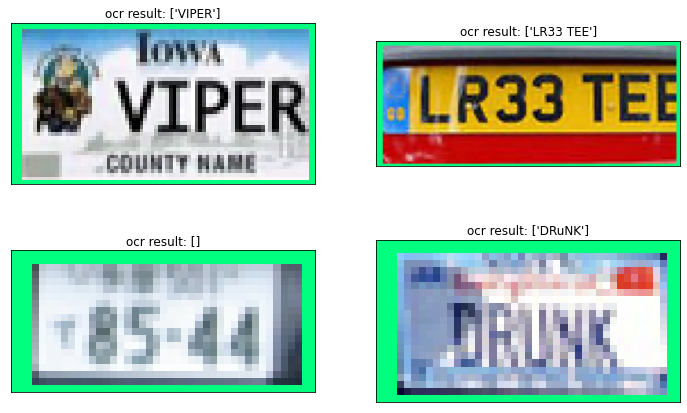

In [14]:
detection_threshold = .85

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(hspace=-.5)
for img, det_dict, ax in zip(detection_images, test_image_detection_dictionaries, axs.reshape(-1)):
    
    img_height, img_width, img_channels = img.shape
    
    high_detection_score_mask = det_dict['detection_scores'] >= detection_threshold
    high_detection_score_boxes = det_dict['detection_boxes'][high_detection_score_mask]
    high_detection_score_classes = det_dict['detection_classes'][high_detection_score_mask]
        
    # Iterates over each license detection
    for box_id, box in enumerate(high_detection_score_boxes):
        
        roi = (box * [img_height, img_width, img_height, img_width]).astype(int)
        x_slice = slice(roi[0], roi[2])
        y_slice = slice(roi[1], roi[3])
        img_filtered = img[x_slice, y_slice]
        
        img_filtered_height, img_filtered_width, _ = img_filtered.shape
        
        easy_ocr_reader = easyocr.Reader(['en'])
        img_ocr = easy_ocr_reader.readtext(img_filtered)
        
        ocr_results = [ocr[1] for ocr in img_ocr]
    
    plt_img = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2RGB)
    ax.imshow(plt_img)
    ax.set_title(f'ocr result: {ocr_results}')
    ax.set_xticks([])
    ax.set_yticks([])
        
plt.show()